# Deep Hedging

You will see in this notebook

In [111]:
import os
import scipy as sp
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.backend.set_floatx('float64')

%matplotlib inline

# Problem formulation and Input Data

We investigate the problem of hedging a Call where the underlying can only be traded with a relative bid-ask spread, i.e. if you by the underlying you have to pay
$$S_{bid}=s\dot S_{mid}$$ and if you sell 

In [2]:
def compute_data(ttm, n_timesteps, n_samples, final_payoff, vol, spot=100.0, ba_spread = 0.0001):
    spot_bid = np.empty((n_samples, n_timesteps,))
    spot_ask = np.empty((n_samples, n_timesteps,))
    payoff = np.zeros((n_samples,n_timesteps,))
    timegrid = np.linspace(0.0, ttm, n_timesteps)
    call_ttm = np.empty((n_samples, n_timesteps,))
    simulated_spot = np.full((n_samples,), spot)
    spot_bid[:,0] = simulated_spot*(1.0-ba_spread*0.5)
    spot_ask[:,0] = simulated_spot*(1.0+ba_spread*0.5)
    
    for i in range(n_samples):
        call_ttm[i,:] = ttm-timegrid
    
    vol_2 = vol**2
    for i in range(1,timegrid.shape[0]):
        dt = timegrid[i]-timegrid[i-1]
        rand = np.random.standard_normal((n_samples,))
        simulated_spot = simulated_spot * np.exp((- 0.5 * vol_2) * dt +
                                         vol * np.sqrt(dt) * rand)
        spot_bid[:,i] = simulated_spot*(1.0-ba_spread*0.5)
        spot_ask[:,i] = simulated_spot*(1.0+ba_spread*0.5)
    payoff[:,-1] = final_payoff(simulated_spot)
    return np.atleast_3d(spot_bid), np.atleast_3d(spot_ask), np.atleast_3d(call_ttm), np.atleast_3d(payoff)

def call_payoff(strike):
    def c(x):
        return np.maximum(x-strike, 0.0)
    return c

strike = 100.0
spot_bid, spot_ask, call_ttm, payoff = compute_data(1.0, n_timesteps=120, n_samples=20000, 
                                                    final_payoff=call_payoff(strike=strike), vol=0.2)

#selection = spot_bid[:,-1,0]>110.0
#spot_bid = spot_bid[selection]
#spot_ask = spot_ask[selection]
#call_ttm = call_ttm[selection]
#payoff = payoff[selection]
f_hedge=np.concatenate([spot_bid/strike, call_ttm], axis=2)

# Creating the network

In [25]:
class Hedger_DO:
    
    @staticmethod
    def get_hedgemodel(m):
        return m.get_layer('time_distributed').layer
        
    
    @staticmethod
    def create_hedge_model(n_features,layers=[{'units':10, 'activation':'tanh'}, {'units':5, 'activation':'tanh'}, {'units':1, 'activation':'linear'}]):
        hedge_input_feat = tf.keras.layers.Input(shape=(n_features), ragged=False, name='hedge_input')
        previous = tf.keras.layers.Dense(name='hedge_model_0', **layers[0])(hedge_input_feat)
        for k in range(1, len(layers)):
            if k < len(layers)-1:
                name = 'hedge_model_'+str(k)
            else:
                name = 'hedge_qty'
            previous = tf.keras.layers.Dense(name = name, **layers[k])(previous)
        return tf.keras.models.Model(name = 'hedge_model', inputs=hedge_input_feat, 
                              outputs=previous)
        return previous
        
    @staticmethod
    def create_model(n_times, n_features,
                     layers=[{'units':10, 'activation':'tanh'}, {'units':5, 'activation':'tanh'}, {'units':1, 'activation':'linear'}]):
        # create hedge model
        #
        hedge_input_feat = tf.keras.layers.Input(shape=(n_times-1, n_features), ragged=False, name='hedge_input')
        if False:
            previous = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(name='hedge_model_0', **layers[0]), name='time_distributed/hedge_model_0')(hedge_input_feat)
            for k in range(1, len(layers)):
                if k < len(layers)-1:
                    name = 'hedge_model_'+str(k)
                else:
                    name = 'hedge_qty'
                previous = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(name = name, **layers[k]), name='time_distributed/'+name)(previous)

            cf_input_hedge_qty = previous
        else:
            hedge_model = Hedger_DO.create_hedge_model(n_features, layers)
            cf_input_hedge_qty = tf.keras.layers.TimeDistributed(hedge_model)(hedge_input_feat)
            
        # In our example, the loss function in the training will be applied the PnL of the hedging strategy on each path.
        # The PnL computation is done in the following lines.
        #
        cf_input_spot_bid = tf.keras.Input(shape=(n_times,1) ,name='CF_input_spot_bid')
        cf_input_spot_ask = tf.keras.Input(shape=(n_times,1) ,name='CF_input_spot_ask')
        
        cf_input_inst_payoff = tf.keras.Input(shape=(n_times,1) ,name='CF_input_call_payoff')
        cf_input_df = tf.keras.Input(shape=(n_times,1) ,name='CF_input_df')

        # hedge cashflows from trades
        cf_dqty_inner = tf.keras.layers.Lambda(lambda x: x[:,1:] - x[:,:-1])(cf_input_hedge_qty)
        cf_dqty0 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.reshape(x[:,0,:], shape=(-1,1,1)))(cf_input_hedge_qty)
        cf_dqtyT = tf.keras.layers.Lambda(lambda x: tf.keras.backend.reshape(-x[:,-1,:], shape=(-1,1,1)))(cf_input_hedge_qty)
        cf_dqty = tf.keras.layers.Concatenate(axis=1)([cf_dqty0, cf_dqty_inner, cf_dqtyT])

        cf_dqty_pos = tf.keras.layers.Lambda(lambda x: tf.keras.backend.minimum(-1.0*x, 0.0))(cf_dqty)
        cf_dqty_neg = tf.keras.layers.Lambda(lambda x: tf.keras.backend.maximum(-1.0*x, 0.0))(cf_dqty)

        cf_hedge_cashflow_buy = tf.keras.layers.Multiply()([cf_dqty_pos, cf_input_spot_ask])
        cf_hedge_cashflow_sell = tf.keras.layers.Multiply()([cf_dqty_neg, cf_input_spot_bid])
        cf_hedge_cashflow = tf.keras.layers.Add(name='CF_hedge_cashflow_trades')([cf_hedge_cashflow_buy, cf_hedge_cashflow_sell])

        # all cashflows collected
        cf_cashflow = tf.keras.layers.Add(name='CF_cashflow_total')([cf_input_inst_payoff, cf_hedge_cashflow])
        # discounted cashflow defines the loss
        cf_loss_timestep = tf.keras.layers.Multiply(name='CF_cashflows_discounted')([cf_input_df, cf_cashflow])
        # aggregate loss output (over time steps)
        cf_loss_value = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1, keepdims=True), name='loss')(cf_loss_timestep)
        
        # return total model
        return tf.keras.models.Model(inputs=[hedge_input_feat, cf_input_spot_bid, cf_input_spot_ask,cf_input_inst_payoff, cf_input_df], 
                              outputs=cf_loss_value)

# Creation and Training

In [11]:
nn_hedge = Hedger_DO.create_model(120, f_hedge.shape[-1], layers = [{'units':10, 'activation':'tanh'}, 
                                                             {'units':5, 'activation':'tanh'}, 
                                                             {'units':1, 'activation':'linear'}])

In [87]:
m.compile( optimizer = tf.keras.optimizers.Adam(lr=0.0025, beta_1=0.9, beta_2=0.999), loss = 'mean_squared_error')

In [13]:
df = np.ones(shape=(f_hedge.shape[0], f_hedge.shape[1], 1.0))# set discount factors to 1 (no discounting)
y = np.zeros((f_hedge.shape[0], ))

In [ ]:
# if you would like to use the tensorboard, uncomment the following lines and adjust the directories accordingly
date = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'C:\\temp\\deep_hedging\\' + date
cb = [tf.keras.callbacks.TensorBoard(profile_batch=0, 
                            log_dir=log_dir, histogram_freq=100),]
cb.append(tf.keras.callbacks.ModelCheckpoint(log_dir + '\\best_model.h5', save_best_only = True))


In [88]:

history = nn_hedge.fit([f_hedge[:,:-1,:], spot_bid, spot_ask, payoff, df], 
                    y, verbose=0,
                    epochs=40,
                    batch_size=20,
                    callbacks=cb,
                    validation_split=0.2)

In [ ]:
date = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'C:\\temp\\deep_hedging\\Adam\\' + date
cb = [tf.keras.callbacks.TensorBoard(profile_batch=0, 
                            log_dir=log_dir, histogram_freq=100),]

if True:
    def scheduler(epoch):
        base_lr = 0.005
        if epoch<100:
            return 1.0*base_lr
        if epoch<250:
            return 0.8*base_lr
        if epoch <500:
            return 0.6*base_lr
        if epoch < 1500:
            return 0.4*base_lr
        if epoch < 2000:
            return 0.2*base_lr
        return 0.1*base_lr
    
    cb.append(tf.keras.callbacks.LearningRateScheduler(
        scheduler, verbose=0
    ))

#cb.append(tf.keras.callbacks.ReduceLROnPlateau(
#    monitor='val_loss', factor=0.8, patience=300, verbose=0, mode='auto',
#    min_delta=0.0001, cooldown=0, min_lr=0))

#cb.append(tf.keras.callbacks.ModelCheckpoint(log_dir + '\\best_model.h5', save_best_only = True))
#history = hedger.fit([f_hedge[:,:-1,:], spot_bid, spot_ask, payoff], np.zeros((spot_bid.shape[0],1)), 
#                     epochs=200, batch_size=100, callbacks=cb, verbose=0, validation_split=0.2) #1000

# Model analysis

In [112]:
def compute_bs(spot, strike, ttm, sigma, r):
    d1 = ( np.log(spot / strike) + (r + 0.5*sigma**2) * ttm ) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    price = spot * sp.stats.norm.cdf(d1) - np.exp(-r * ttm) * strike * sp.stats.norm.cdf(d2)
    delta = sp.stats.norm.cdf(d1)
    return price, delta

In [89]:
hedge_model = Hedger_DO.get_hedgemodel(m)

In [109]:
ttm = 0.1

rel_spots = np.arange(0.5,1.5, 0.010)
x=np.empty(shape=(rel_spots.shape[0], 2))
x[:,0] = rel_spots
x[:,1] = ttm

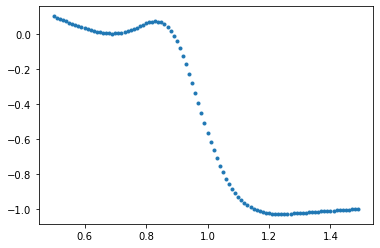

In [110]:
#plt.plot(spot_bid[:,-1,0],payoff[:,-1,0],'.')
#plt.figure()
delta = hedge_model.predict(x)
plt.plot(x[:,0],delta[:,0],'.')
#plt.plot(spot_bid[:,118,0],delta[:,118,0],'.')
#plt.plot(spot_ask[:,20,0],delta[:,20,0],'.')
#plt.plot(spot_ask[:,100,0],delta[:,100,0],'.')

In [85]:
rel_strike = 0.9
t = np.arange(0.0,1.0,0.001)

x = np.empty(shape=(ttm.shape[0], 2))
x[:,0] = rel_strike
x[:,1] = 1.0-t

Text(0, 0.5, 'delta')

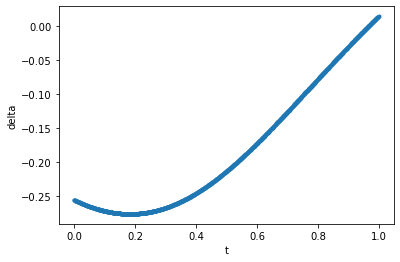

In [86]:
plt.plot(1.0-ttm, hedge_model.predict(x), '.')
plt.xlabel('t')
plt.ylabel('delta')

In [ ]:
plt.hist(spot_bid[:,10,0])